(content:references:tabular_part2)=
# Grids of Stellar Models Part 2: *Interpolation*

***Author: Marc Hon***

In [](content:references:tabular_part1), we were introduced to grids of evolutionary tracks and isochrones, which are generated from a combination of initial conditions, such as mass and metallicity. 


In [1]:
import os
import yaml
import torch
import corner
import scienceplots
import random
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

from matplotlib.cm import ScalarMappable
from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from astropy import coordinates as coords
from scipy.stats import truncnorm, norm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.use('science'); fs=15

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter3' / 'data'

## Isochrones and Evolutionary Phases

Here, we will examine a grid of models varied in initial mass and initial metallicity along the red giant branch phase of evolution.

In [2]:
rg_grid = pd.read_csv(str(data_folder_path) + '/RG_grid.csv').set_index(['initial_mass', 'initial_met', 'step'])
rg_grid

teff       rad       age
initial_mass initial_met step                              
1.3          -1.25       453   3.941125  0.237314  2.205380
                         454   3.937966  0.247855  2.217799
                         455   3.934595  0.258536  2.228859
                         456   3.931033  0.269315  2.238671
                         457   3.927306  0.280156  2.247375
...                                 ...       ...       ...
2.1           0.50       701   3.638026  1.217787  1.518331
                         702   3.636780  1.227291  1.518392
                         703   3.635558  1.236729  1.518443
                         704   3.634333  1.246124  1.518488
                         705   3.633113  1.255467  1.518526

[81570 rows x 3 columns]

### Input Parameters, $\mathbf{y}$

| **Column**     | **Description**                                                                 |
|----------------|----------------------------------------------------------------------------------|
| `initial_mass`            | Initial stellar mass (in solar masses, $M_\odot$)                        |
| `initial_met`            | Initial metallicity, [Fe/H]           |
| `step`            | Equivalent Evolutionary Phase (EEP) of the stellar model along the evolutionary track/isochrone            |


### Output Observable Parameters, $\mathbf{x}$

| **Column**     | **Description**                                                                 |
|----------------|----------------------------------------------------------------------------------|
| `teff`            | Effective temperature, $T_{\mathrm{eff}}$ (K)                        |
| `rad`            | Stellar radius, $R_{\odot}$           |
| `age`            | Stellar age (Gyr)   |


```{admonition} What is an Equivalent Evolutionary Phase (EEP)?
:class: note

Stellar models evolve at *non-uniform rates* across different phases (e.g., slowly on the main sequence, quickly through the giant branch). This makes comparing different stars or interpolating between models difficult, especially when age is used as the interpolation parameter. For instance, while an age of 1 Gyr may correspond to a **low-mass star still burning hydrogen on the main sequence**, it also corresponds to a **high-mass star burning helium as a red giant**.

To solve this, [Dotter et al. (2016)](https://iopscience.iop.org/article/10.3847/0067-0049/222/1/8) define **Equivalent Evolutionary Phases (EEPs)** — standardized markers that divide a stellar track into physically meaningful and uniformly spaced *phases of evolution* rather than time steps. EEPs align similar physical stages across stars of different masses and metallicities, and have two distinctions:

- **Primary EEPs** represent distinct, physically motivated phases along a star's lifetime.
- **Secondary EEPs** provide a uniform spacing between the primary EEPs in each track.


```{figure} images/eep.png
---
height: 300px
width: 800px
name: eep
---
Evolutionary tracks and EEPs adapted from [Dotter et al. (2016)](https://iopscience.iop.org/article/10.3847/0067-0049/222/1/8). (Left) An evolutionary track of a $1_M{\odot}$ star, with main evolutionary phases (EEPs) marked with larger dots and annotated. The secondary EEPs are indicated by the smaller dots. (Right) This distribution of primary and secondary EEPs for three stellar evolution tracks with initial masses of $0.95M_{\odot}, 1M_{\odot},$ and $1.05M_{\odot}$. **EEPs enable meaningful interpolation across different evolutionary tracks, even when those tracks evolve at different rates in time.**

```

To be useful in inferring stellar parameters, these grids should cover a range of values across the input parameter space. The central question here is:

***
**How should the input parameter space be sampled to provide the best coverage?**
***


The most convenient (and common) approach is to perform uniform sampling:

In [3]:
def plot_uniform_grid(m_, f_):
    fig = plt.figure(figsize=(12,6))
    ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)

    ax1.scatter(rg_grid.index.get_level_values('initial_mass').values,
               rg_grid.index.get_level_values('initial_met').values, c='k', s=10)

    s = np.unique(rg_grid.index.get_level_values('step').values)
    unique_mass_met = np.unique(np.column_stack((rg_grid.index.get_level_values('initial_mass').values,
                                                 rg_grid.index.get_level_values('initial_met').values)), axis=0)

    for row in unique_mass_met:
        if row[0] == m_:
            ax1.scatter(row[0], row[1], c='magenta', s=85)

            ax2.plot( 10**rg_grid.loc[(m_, row[1], s)]['teff'],
                 10**rg_grid.loc[(m_, row[1], s)]['rad'], color='magenta',
                lw=2)
        if row[1] == f_:
            ax1.scatter(row[0], row[1], c='orange', s=25)
            ax3.plot( 10**rg_grid.loc[(row[0], f_, s)]['teff'],
                 10**rg_grid.loc[(row[0], f_, s)]['rad'], color='orange',
                lw=0.25)

    for ax in [ax2, ax3]:
        ax.set_yscale('log')
        ax.set_xlim(3000, 5500)
        ax.set_ylim(6, 150)
        ax.invert_xaxis()
        ax.set_xlabel('$T_{\\mathrm{eff}}$ (K)', fontsize=fs)
        ax.set_ylabel('Radius ($R_{\\odot}$)', fontsize=fs)

    ax1.set_xlabel('Initial Mass ($M_{\\odot}$)', fontsize=fs)
    ax1.set_ylabel('Initial Metallicity (dex)', fontsize=fs)
    ax2.set_title('Fixed Initial Mass (%.1f $M_{\\odot}$)'%(m_))
    ax3.set_title('Fixed Initial Metallicity (%.2f dex)'%(f_))

    plt.tight_layout()

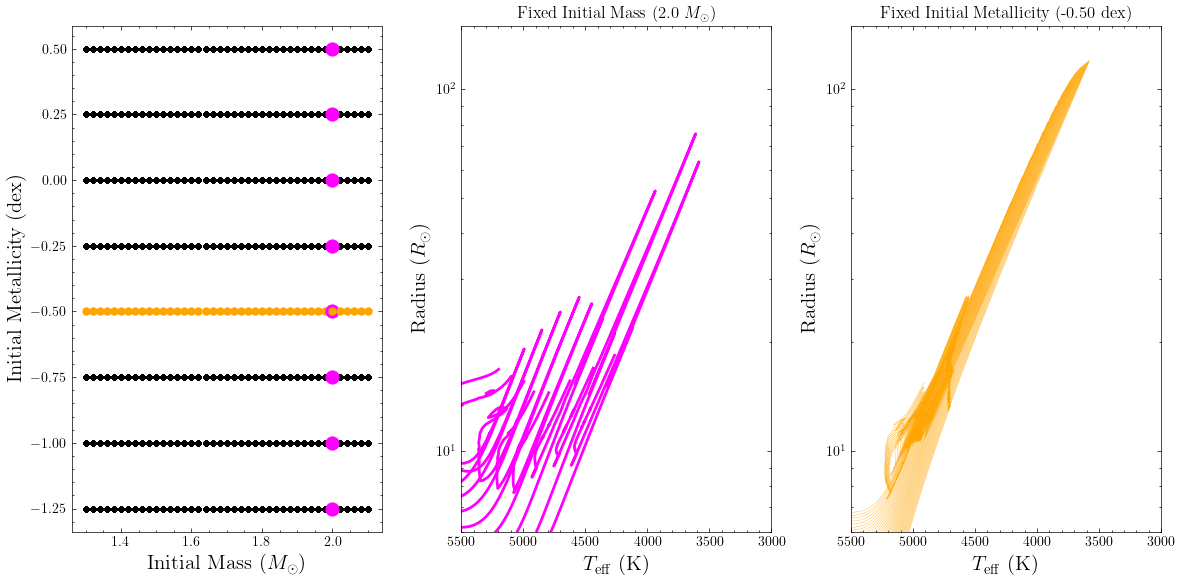

In [159]:
init_mass = 2
init_metallicity = -0.5
plot_uniform_grid(init_mass, init_metallicity)

The above left shows a grid of models regularly spaced in initial mass and metallicity. The models in <span style="color: magenta">pink</span> indicate tracks varied in initial metallicity at a fixed initial mass, while the models in <span style="color: orange">orange</span> indicate tracks varied in initial mass at a fixed initial metallicity.
`````{admonition} Variation of evolutionary tracks
:class: note
In the code block above, `init_mass` and `init_metallicity` control which values of initial mass and metallicity are highlighted from the uniform grid, respectively.

- Vary both of these parameters, one at a time, within the permissible range of the grid of models. What happens to the tracks, and in which direction do they move?
- Which parameter (`init_mass` or `init_metallicity`) has the larger influence on the maximum extent of stellar models in radius and in modifying the surface temperature of the star?

`````

## The Curse of Dimensionality

Despite the convenience of uniform sampling, such a sampling strategy struggles to provide sufficient coverage of the parameter space in higher dimensions. Compare the following sampling coverage in 2D:

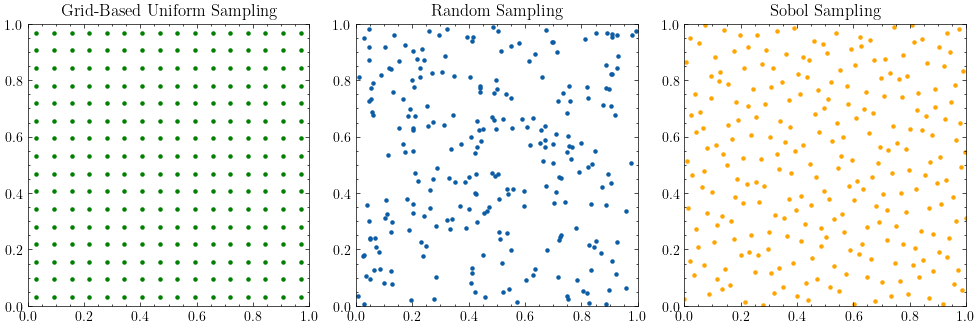

In [2]:
from scipy.stats import qmc

n = 256
dim = 2

random_samples = np.random.rand(n, dim)

grid_size = int(np.sqrt(n))
grid_x, grid_y = np.meshgrid(
    np.linspace(0, 1, grid_size, endpoint=False) + 0.5 / grid_size,
    np.linspace(0, 1, grid_size, endpoint=False) + 0.5 / grid_size
)
grid_samples = np.column_stack([grid_x.ravel(), grid_y.ravel()])

sobol_engine = qmc.Sobol(d=dim, scramble=True)
sobol_samples = sobol_engine.random(n)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].scatter(grid_samples[:, 0], grid_samples[:, 1], s=5, color='green')
axs[0].set_title('Grid-Based Uniform Sampling')

axs[1].scatter(random_samples[:, 0], random_samples[:, 1], s=5)
axs[1].set_title('Random Sampling')

axs[2].scatter(sobol_samples[:, 0], sobol_samples[:, 1], s=5, color='orange')
axs[2].set_title('Sobol Sampling')

for ax in axs:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In 2D, uniformly sampled points may seem well distributed to the eye. However, in higher dimensions:

- The volume of the space increases exponentially, while the number of samples may remain fixed.

- The distance between neighboring points increases, leaving large gaps in the sampled space.

- Most points tend to lie near the edges or corners of the domain, not near the center.

The following plot shows this by calculating the average pairwise distance between sampling approaches over an increasing number of dimensions.

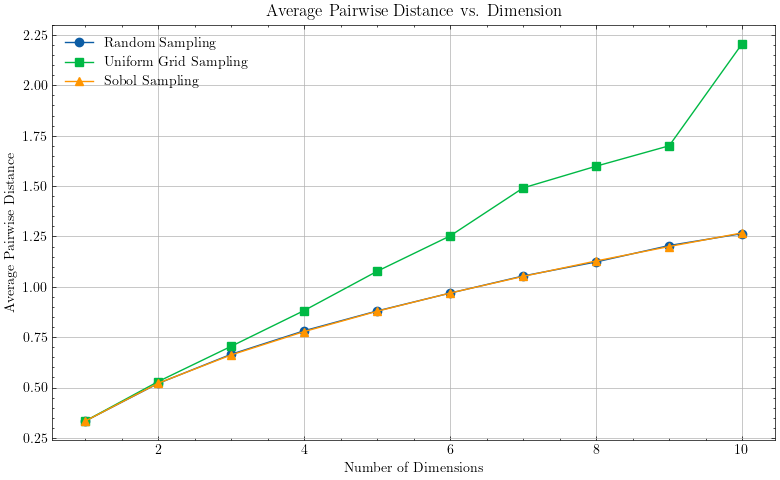

In [10]:
from scipy.spatial.distance import pdist
from scipy.stats import qmc

n_samples = 1024*4
seed = 42
rng = np.random.default_rng(seed)

dims = range(1, 11)
avg_dist_random = []
avg_dist_uniform = []
avg_dist_sobol = []

for d in dims:
    rand_pts = np.random.rand(n_samples, d)
    avg_dist_random.append(np.mean(pdist(rand_pts)))

    grid_pts_1d = np.linspace(0, 1, int(np.round(n_samples ** (1 / d))))
    mesh = np.meshgrid(*([grid_pts_1d] * d), indexing='ij')
    grid_pts = np.stack(mesh, axis=-1).reshape(-1, d)
    idx = rng.choice(grid_pts.shape[0], grid_pts.shape[0], replace=False)
    grid_pts = grid_pts[idx]
    
#     grid_pts = grid_pts[:n_samples]  # Trim to match n_samples
    avg_dist_uniform.append(np.mean(pdist(grid_pts)))

    sobol_engine = qmc.Sobol(d=d, scramble=True)
    sobol_pts = sobol_engine.random(n=n_samples)
    avg_dist_sobol.append(np.mean(pdist(sobol_pts)))

plt.figure(figsize=(8, 5))
plt.plot(dims, avg_dist_random, 'o-', label='Random Sampling')
plt.plot(dims, avg_dist_uniform, 's-', label='Uniform Grid Sampling')
plt.plot(dims, avg_dist_sobol, '^-', label='Sobol Sampling')
plt.xlabel('Number of Dimensions')
plt.ylabel('Average Pairwise Distance')
plt.title('Average Pairwise Distance vs. Dimension')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Although both random and Sobol sampling may show similar *average distances* between points in high-dimensional space, this does not mean they cover the space equally well.

- Random sampling can leave clumps and gaps.
- Sobol sampling aims to fill the space evenly, which is better for interpolation, optimization, and numerical integration.

This is why metrics like **centered discrepancy** are often more informative than just pairwise distance.

```{admonition} What is Sobol Sampling?
:class: tip

**Sobol sequences** are a class of *quasi-random low-discrepancy sequences* designed to sample points in high-dimensional spaces more uniformly than purely random or grid-based methods. They are particularly effective for numerical integration, model interpolation, and stellar grid sampling.

> *Sobol numbers are a sequence of $m$-dimensional vectors $x_1, x_2, \dots, x_n$ in the unit hypercube $[0,1]^m$, constructed such that the integral of a real function $f$ in that space is equivalent in the limit to the function evaluated over the sequence:*
>
> $$
\int_{[0,1]^m} f(x)\,dx = \lim_{n \to \infty} \frac{1}{n} \sum_{i=1}^{n} f(x_i)
$$
> with the sequence being chosen such that the convergence is
achieved as quickly as possible *(Bellinger et al. 2016, ApJ 830:31)*.

Sobol sampling ensures that model grids (e.g., over mass, metallicity, age, etc.) fill the space as uniformly as possible, while avoiding clumping or redundant sampling.

**See also**: [Bellinger et al. (2016)](https://iopscience.iop.org/article/10.3847/0004-637X/830/1/31/pdf), *Figure 14* — a comparison of linear, random, and Sobol sampling in a 3D unit cube projected onto 2D, showing the superior space-filling behavior of Sobol methods.

```

### The Discrepancy Metric


The **centered L²-discrepancy** is a measure of how uniformly a set of sample points fills a multi-dimensional unit cube $[0, 1]^d$. It is particularly useful for comparing different sampling strategies.

In high-dimensional inference (e.g., stellar modeling), uniform coverage of parameter space becomes difficult. Discrepancy helps assess **how well your sample points cover the space**, especially near the center and along diagonals, which are places where random sampling tends to leave gaps.


Let $\mathbf{x}^{(i)} \in [0,1]^d$ be the $i$-th point in a set of $n$ total samples. Then the **centered L²-discrepancy** $D_C^2(P)$ is given by [Hickernell (1998)](https://ui.adsabs.harvard.edu/abs/1998MaCom..67..299H/abstract) as:

$$
D_C^2(P) = \overbrace{\left( \frac{13}{12} \right)^d}^{\text{Term 1}}
- \overbrace{\frac{2}{n} \sum_{i=1}^n \prod_{j=1}^d \left(1 + \frac{1}{2}|x^{(i)}_j - 0.5| - \frac{1}{2}(x^{(i)}_j - 0.5)^2 \right)}^{\text{Term 2}} 
+ \overbrace{\frac{1}{n^2} \sum_{i=1}^n \sum_{k=1}^n \prod_{j=1}^d \left(1 - \max(x^{(i)}_j, x^{(k)}_j) \right)}^{\text{Term 3}}
$$


- **Term 1**: Reference value for perfect uniformity:  
  $\left( \frac{13}{12} \right)^d$

- **Term 2**: Penalizes deviation from the center. The product ensures that offset from 0.5 is measured across all dimensions.

- **Term 3**: Penalizes clustering. This double sum detects whether points are too close to each other in high-dimensional space.

Overall, this form of measuring discrepancy promotes evenly spread points with good center coverage, and penalizes points that are clumped or miss the center with a high discrepancy value.

In practice, `scipy.stats.qmc.discrepancy()` can be used to compute it for sampled point sets.

In [133]:
from scipy.stats import qmc

## Number Of Samples ##
n = 512
dim = 2

## Generate 2D Uniform Samples ##
num_per_dim = int(n ** (1/dim))
linspace = np.linspace(0, 1, num_per_dim)
mesh = np.meshgrid(*([linspace] * dim))
uniform_points = np.stack(mesh, -1).reshape(-1, dim)
uniform_discrep = qmc.discrepancy(uniform_points) # uniform sample discrepancy

## Generate 2D Random Samples ##
random_samples = np.random.rand(n, dim)
random_discrep = qmc.discrepancy(random_samples) # random sample discrepancy

## Generate 2D Sobol Samples ##
sobol_engine = qmc.Sobol(d=dim, scramble=True)
sobol_samples = sobol_engine.random(n)
sobol_discrep = qmc.discrepancy(sobol_samples) # Sobol sample discrepancy

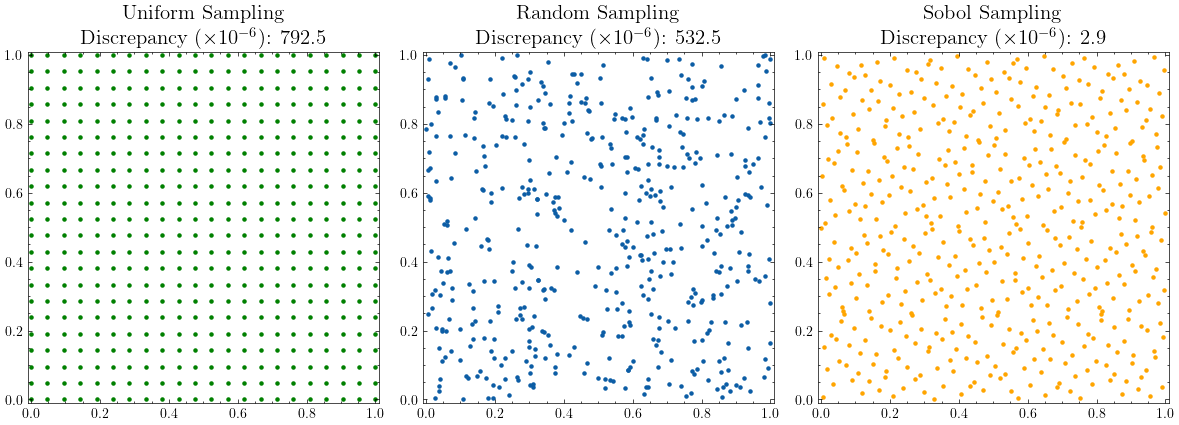

In [150]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].scatter(uniform_points[:, 0], uniform_points[:, 1], s=5, color='green')
axs[0].set_title('Uniform Sampling\nDiscrepancy ($\\times 10^{-6}$): %.1f' %(uniform_discrep/1e-6),
                fontsize=fs)
axs[1].scatter(random_samples[:, 0], random_samples[:, 1], s=5)
axs[1].set_title('Random Sampling\nDiscrepancy ($\\times 10^{-6}$): %.1f' %(random_discrep/1e-6),
                fontsize=fs)
axs[2].scatter(sobol_samples[:, 0], sobol_samples[:, 1], s=5, color='orange')
axs[2].set_title('Sobol Sampling\nDiscrepancy ($\\times 10^{-6}$): %.1f' %(sobol_discrep/1e-6),
                fontsize=fs)

for ax in axs:
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

We can see that as the number of dimensions increase, Sobol sampling provides the lowest discrepancy compared to uniform and random sampling.

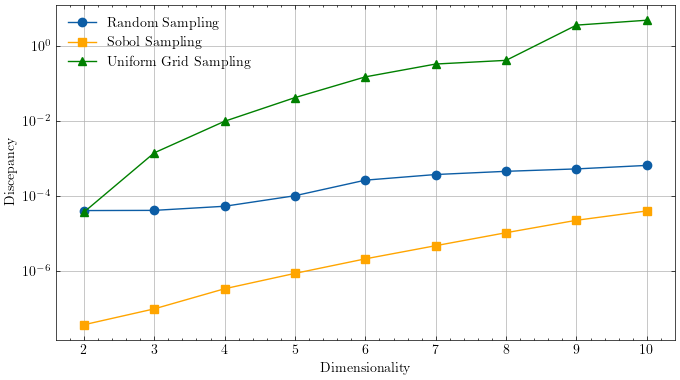

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

# Settings
dimensions = np.arange(2, 11)
samples = 10000

# Storage for results
discrep_random = []
discrep_sobol = []
discrep_grid = []

for d in dimensions:
    
    # Random sampling
    rand_points = np.random.rand(samples, d)
    discrep_random.append(qmc.discrepancy(rand_points))
    
    # Sobol sampling
    sampler = qmc.Sobol(d, scramble=False)
    sobol_points = sampler.random(samples)
    discrep_sobol.append(qmc.discrepancy(sobol_points))

    num_per_dim = int(samples ** (1/d))
    linspace = np.linspace(0, 1, num_per_dim)
    mesh = np.meshgrid(*([linspace] * d))
    grid_points = np.stack(mesh, -1).reshape(-1, d)
    discrep_grid.append(qmc.discrepancy(grid_points))

# Plotting
plt.figure(figsize=(7,4))
plt.plot(dimensions, discrep_random, 'o-', label='Random Sampling')
plt.plot(dimensions, discrep_sobol, 's-', label='Sobol Sampling', color='orange')
plt.plot(dimensions, discrep_grid, '^-', label='Uniform Grid Sampling', color='green')
plt.xlabel('Dimensionality')
plt.ylabel('Discepancy')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Linear Interpolation using EEPs


The EEPs provide a regular set of points over which we can perform linear interpolation. To facilitate this, we can use the [`DFInterpolator`](https://isochrones.readthedocs.io/en/latest/interpolate.html) tool from the `isochrones` library:

```
from isochrones.interp import DFInterpolator

interpolator = DFInterpolator(dataframe)
```


```{admonition} Interpolating with DFInterpolator
:class: important

`DFInterpolator` enables multi-dimensional interpolation over specified DataFrame columns by treating them as interpolation axes. To use it, the relevant columns must first be moved into the DataFrame index using:
`df.set_index(['col1', 'col2', 'col3', ...])`.
This defines the coordinate space over which interpolation is performed. The remaining columns in the DataFrame are then treated as the target quantities to be interpolated.

```

To see this in action, let us first split the grid of models into a **sub-sampled subset** that we will use for the interpolation, and a separate **hold-out** subset that we will use to examine the interpolation quality.

In [4]:
def get_subsampled_grid(subsampling_factor_mass, subsampling_factor_feh):

    x_mass = rg_grid.index.get_level_values('initial_mass').values
    x_feh = rg_grid.index.get_level_values('initial_met').values

    unique_mass_met = np.unique(np.column_stack((x_mass,x_feh)), axis=0) # unique tuples of mass and met

    subsampled_mass = np.unique(x_mass)[1:-1:subsampling_factor_mass]
    subsampled_mass = np.insert(subsampled_mass, 0, np.unique(x_mass)[0])
    subsampled_mass = np.append(subsampled_mass, np.unique(x_mass)[-1])

    subsampled_feh = np.unique(x_feh)[1:-1:subsampling_factor_feh]
    subsampled_feh = np.insert(subsampled_feh, 0, np.unique(x_feh)[0])
    subsampled_feh = np.append(subsampled_feh, np.unique(x_feh)[-1])

    subsampled_massmet = unique_mass_met[
        np.isin(unique_mass_met[:, 0], subsampled_mass) & np.isin(unique_mass_met[:, 1], subsampled_feh)]

    validation_massmet = unique_mass_met[
        ~(np.isin(unique_mass_met[:, 0], subsampled_mass) & np.isin(unique_mass_met[:, 1], subsampled_feh))]

    reduc = np.isin(x_mass, subsampled_massmet[:,0]) & np.isin(x_feh, subsampled_massmet[:,1])

    x_mass_subsampled, x_feh_subsampled = (arr[reduc] for arr in (x_mass, x_feh))
    x_mass_holdout, x_feh_holdout = (arr[~reduc] for arr in (x_mass, x_feh))
    
    return x_mass_subsampled, x_feh_subsampled, x_mass_holdout, x_feh_holdout

Here, `subsampling_factor_mass` and `subsampling_factor_feh` controls the degree to which the grid is subsampled in initial mass and initial metallicity.

In [5]:
subsampling_factor_mass = 2 # integer factor to which initial mass in the grid is subsampled
subsampling_factor_feh = 1 # integer factor to which initial metallicity in the grid is subsampled

x_mass_subsampled, x_feh_subsampled, \
x_mass_holdout, x_feh_holdout = get_subsampled_grid(subsampling_factor_mass, subsampling_factor_feh)

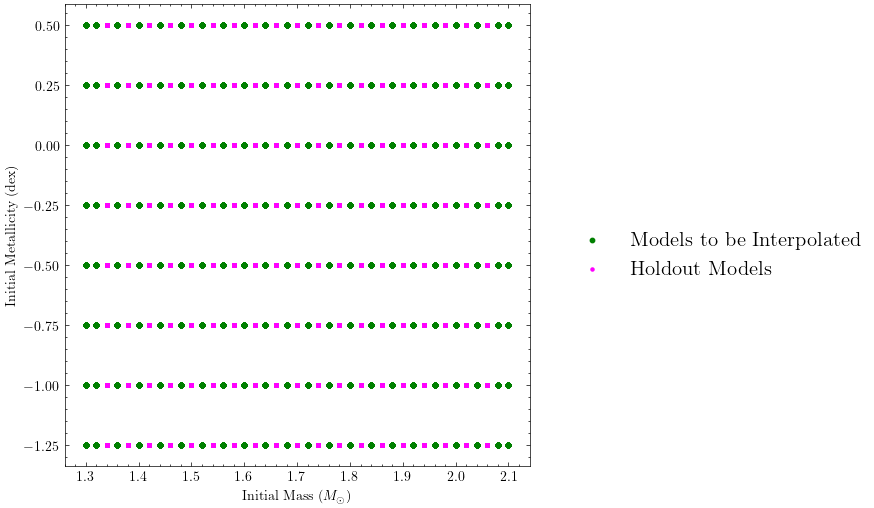

In [6]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x_mass_subsampled, x_feh_subsampled, s=10, c='green', label= 'Models to be Interpolated')
ax1.scatter(x_mass_holdout, x_feh_holdout, s=5, c='magenta', label = 'Holdout Models')
ax1.set_ylabel('Initial Metallicity (dex)'); ax1.set_xlabel('Initial Mass ($M_{\\odot}$)')
ax1.legend(prop={'size': fs}, bbox_to_anchor=(1.05, 0.55))
plt.show()

```{note} 
The downsampling by `get_subsampled_grid` preserves models near the edge of the grid to make sure that the interpolation is kept consistently within boundaries. In other words, no extrapolation occurs.
```

In the following, we define
- `training_df`: DataFrame containing initial mass and metallicity of models to be interpolated over
- `validation_df` DataFrame containing initial mass and metallicity of holdout models

In [7]:
## Training DF ##

## find unique subsampled initial mass and initial metallicity ##
subsampled_massmet = np.unique(np.column_stack((x_mass_subsampled,x_feh_subsampled)), axis=0)
selected_pairs =  [tuple(row) for row in subsampled_massmet]

## build a mask over the original DataFrame to select only those subsampled values ##
mask = rg_grid.index.to_frame(index=False)[['initial_mass', 'initial_met']].apply(tuple, axis=1).isin(selected_pairs)

## Use the mask to subset the original DataFrame
training_df = rg_grid.reset_index()[mask]


## Validation DF ##

validation_massmet = np.unique(np.column_stack((x_mass_holdout,x_feh_holdout)), axis=0)
selected_pairs =  [tuple(row) for row in validation_massmet]
mask = rg_grid.index.to_frame(index=False)[['initial_mass', 'initial_met']].apply(tuple, axis=1).isin(selected_pairs)
validation_df = rg_grid.reset_index()[mask]

In [8]:
training_df = training_df.set_index(['initial_mass', 'initial_met', 'step'])
training_df.head()

teff       rad       age
initial_mass initial_met step                              
1.3          -1.25       453   3.941125  0.237314  2.205380
                         454   3.937966  0.247855  2.217799
                         455   3.934595  0.258536  2.228859
                         456   3.931033  0.269315  2.238671
                         457   3.927306  0.280156  2.247375

In [9]:
validation_df = validation_df.set_index(['initial_mass', 'initial_met', 'step'])
validation_df.head()

teff       rad       age
initial_mass initial_met step                              
1.34         -1.25       453   3.951350  0.238106  1.991584
                         454   3.948183  0.248621  2.003444
                         455   3.944806  0.259264  2.013925
                         456   3.941241  0.269994  2.023172
                         457   3.937502  0.280782  2.031301

With the indices now defined, it is straightforward to define the linear interpolator:

In [195]:
from isochrones.interp import DFInterpolator

train_interpolator = DFInterpolator(training_df)

The syntax for the interpolation is 
```
train_interpolator([initial_mass, initial_met, step])
```

```{hint} 
Experiment with a variety of values in `train_interpolator`, including a list of values. For instance, 

> `train_interpolator([ [1.5, 1.6], [-0.5, 0.2], [455, 455]])`

provides:

- The interpolation at EEP 455 of a model with initial mass of 1.5 $M_{\odot}$ and an initial metallicity of -0.5 dex.
- The interpolation at EEP 455 of a model with initial mass of 1.6 $M_{\odot}$ and an initial metallicity of 0.2 dex at the same EEP.

Meanwhile,

> `train_interpolator([ [1.5, 1.5], [-0.5, -0.5], [454, 455]])`

Provides interpolation across EEPs 454 and 455 for a model withinitial mass of 1.5 $M_{\odot}$ and an initial metallicity of -0.5 dex. 

In `plot_linear_interpolations` below, experiment with varying `idx` to change the reference mass at which the interpolation occurs.
```

This allows interpolation at individual values or across a continuous range, shown in the following:

In [299]:
def plot_linear_interpolations(fixed_mass):
    
    met_range = np.linspace(-1.25, 0.5, 100)
    steps = np.unique(rg_grid.index.get_level_values('step').values)
    
    fig = plt.figure(figsize=(12, 5))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)

    cmap = mpl.colormaps['viridis']
    norm = Normalize(vmin=met_range.min(), vmax=met_range.max())
    for row in validation_massmet:
        if row[0] == fixed_mass:
            init_metallicity = row[1]
            ax1.plot( 10**validation_df.loc[(fixed_mass, init_metallicity, steps)]['teff'],
                     10**validation_df.loc[(fixed_mass, init_metallicity, steps)]['rad'], color='magenta',
                    lw=2)
            ax1.scatter( 10**train_interpolator([fixed_mass, init_metallicity, steps])[::3,0],
                     10**train_interpolator([fixed_mass, init_metallicity, steps])[::3,1], color='k', s=7, zorder=999)
            
            for met in met_range:
                color = cmap(norm(met))

                ax2.plot( 10**train_interpolator([fixed_mass, met, steps])[:,0],
                         10**train_interpolator([fixed_mass, met, steps])[:,1], c=color, ls='--',
                        lw=2)           
    for ax in [ax1, ax2]:         
        ax.set_yscale('log')
        ax.set_xlim(3000, 6500)
        ax.set_ylim(3, 180)
        ax.invert_xaxis()
        ax.set_xlabel('$T_{\\mathrm{eff}}$ (K)', fontsize=fs)
        ax.set_ylabel('Radius ($R_{\\odot}$)', fontsize=fs)

    ax1.plot([],[], color='magenta',
                lw=2, label='Holdout Tracks')
    ax1.scatter([],[], c='k',
                s=55, label='Interpolated EEPs')
    ax1.legend(loc='lower right', prop={'size': fs-3})
    ax1.text(x=0.1, y=0.9, s=f'Initial [Fe/H] from {met_range[0]:.2f} to {met_range[-1]:.2f} dex\nin increments of 0.25 dex',
            transform=ax1.transAxes)
    
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax2, label='Initial Metallicity (dex)')
    plt.show()

Fixed Mass is 1.86 Msol


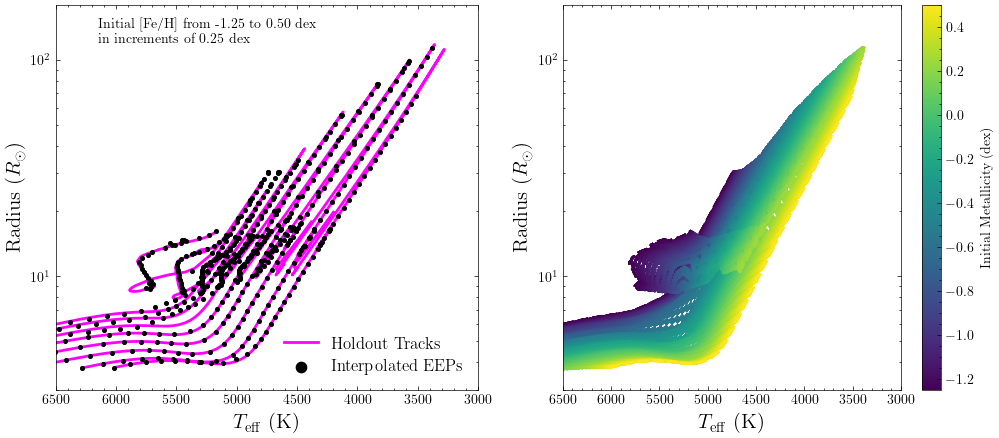

In [300]:
idx = 13
fixed_mass = np.unique(validation_massmet[:,0])[idx]
print(f'Fixed Mass is {fixed_mass} Msol')

plot_linear_interpolations(fixed_mass)

On the left, we are interpolating from the downsampled grid to an **initial mass value only present in the validation set of models**. At that initial mass value, we are examining the interpolation over a **discrete range** of initial metallicities, matching the grid values of (`initial_mass`, `initial_met`) in the validation set.


On the right, we see that interpolation allows us to estimate the evolutionary tracks across **a continuous range** of initial metallicity values.

**Key Observations**

> - The interpolated EEPs are not perfect. It may be inaccurate $T_{\mathrm{eff}}-$radius regions where the tracks evolve quickly.
> - By interpolating over a continuous range, we observe that output stellar properties are **mostly smoothly varying** with respect to the input parameters. 

## Beyond Linear Interpolation: Emulation

While linear interpolation is a simple and effective way to estimate stellar properties between known grid points, it encounters significant limitations in higher-dimensional parameter spaces:

- **Dimensionality scaling**: In D-dimensional space, linear interpolation becomes increasingly inaccurate as the number of input parameters grows as the space between points grow larger.

- **Grid rigidity**: Traditional interpolation requires a grid regularly sampled in Equivalent Evolutionary Phases (EEPs). Defining EEPs is an added complication, given that evolutionary tracks often vary in length and sampling. 

- **Nonlinearity**: Stellar properties change nonlinearly across parameters like mass, metallicity, and age. Linear methods poorly approximate such curvature, especially near key evolutionary transitions.

### Emulating Stellar Grids with Neural Networks

Instead of relying on interpolation, we can learn a continuous, differentiable mapping from stellar parameters (e.g., mass, age, [Fe/H]) to observables (e.g., $T_{\mathrm{eff}}$, $\log (g)$, asteroseismic values) using a neural network emulator. As seen in [](content:references:spectra_part3), neural networks can be used to emulate high-dimensional data very effectively. In the context of a grid of models, this method in principle will be able to:

- Handle $D-D$ interpolation naturally without requiring a structured grid.
- Capture nonlinear variations across parameter space more accurately than linear interpolators.
- Relax the requirement for EEPs or regridding as the model learns directly from raw evolutionary track outputs.

This motivates our next step: training a neural emulator to serve as a flexible surrogate model of the stellar grid.

## Normalizing Flows as a Grid Emulator

Instead of using an ordinary multilayer perceptron as our emulator, we will use **normalizing flows** to perform the task. The key insight here is that the input parameter space and the observable space spanned by the grid can be thought of as **multi-dimensional conditional distributions** to be modelled by the flow.


We will use a Neural Spline Flow as implemented by the `zuko` library to model the output observable distribution, $\mathbf{y}$ **conditioned** on the input parameter space, $\mathbf{x}$. This forms a **Conditional Normalizing Flow** that maps the multi-dimensional distributions $\mathbf{x}$ and $\mathbf{y}$.

In [10]:
### IMPORTS ###

import torch, zuko
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
teff_scaler = StandardScaler()

In [11]:
## Define Training Set and Torch Dataloader ##

x_mass_train = training_df.reset_index()['initial_mass'].values
x_feh_train = training_df.reset_index()['initial_met'].values

y_teff_train = training_df.reset_index()['teff'].values
y_teff_train = teff_scaler.fit_transform(y_teff_train.reshape(-1,1)).squeeze()
y_rad_train = training_df.reset_index()['rad'].values
y_age_train = training_df.reset_index()['age'].values

X_train = torch.Tensor(np.vstack([ x_mass_train, x_feh_train]).T).to(device)
Y_train = torch.Tensor(np.vstack([ y_teff_train, y_rad_train, y_age_train]).T).to(device)

train_dataset = utils.TensorDataset(X_train, Y_train)
train_dataloader = utils.DataLoader(train_dataset, shuffle=True, batch_size=64)

In [12]:
flow = zuko.flows.NSF(features=Y_train.size(1),  context=X_train.size(1), 
                      transforms=X_train.size(1), hidden_features=[512] * 4).to(device) # define the flow

optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr = 1E-12)
iterations = 150

In [13]:
## Training Loop ##

i = 0

for _ in range(iterations):
    i+= 1
    loss_vec = []
    flow.train()
    
    for (X_inp, Y_inp) in train_dataloader:
        
        loss = -flow(X_inp).log_prob(Y_inp)
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_vec.append(loss.detach().item())
        
#     flow.eval()
#     with torch.no_grad():
#
#     ####################################################### 
#     ###  Insert Code Block for Validation Testing Here ####
#     ####################################################### 
#      
#     ####################################################### 
        
    scheduler.step(np.mean(loss_vec))

    print('Iterations: %d/%d, Train Loss: %.4f' %(i, iterations, np.mean(loss_vec))) if i % 10 == 0 else None

Iterations: 10/150, Train Loss: -4.2067
Iterations: 20/150, Train Loss: -4.9759
Iterations: 30/150, Train Loss: -5.4604
Iterations: 40/150, Train Loss: -5.7503
Epoch 00047: reducing learning rate of group 0 to 5.0000e-04.
Iterations: 50/150, Train Loss: -6.6224
Iterations: 60/150, Train Loss: -6.9687
Epoch 00067: reducing learning rate of group 0 to 2.5000e-04.
Iterations: 70/150, Train Loss: -7.7747
Iterations: 80/150, Train Loss: -7.9877
Epoch 00087: reducing learning rate of group 0 to 1.2500e-04.
Iterations: 90/150, Train Loss: -8.5918
Epoch 00099: reducing learning rate of group 0 to 6.2500e-05.
Iterations: 100/150, Train Loss: -9.0844
Iterations: 110/150, Train Loss: -9.1589
Epoch 00119: reducing learning rate of group 0 to 3.1250e-05.
Iterations: 120/150, Train Loss: -9.4502
Epoch 00125: reducing learning rate of group 0 to 1.5625e-05.
Iterations: 130/150, Train Loss: -9.5911
Iterations: 140/150, Train Loss: -9.6263
Epoch 00141: reducing learning rate of group 0 to 7.8125e-06.
I

### Visualizing the Emulated Distribution from the Trained Flow

Given that we are treating the grid of models as a **continuous distribution**, we can use a corner plot to visualize how the emulation of output parameters compares to the original, **when conditioned on the same distribution of input parameters.**

In [25]:
y_samps = []
y_logprobs = []
y_s = []
x_s = []

for (X_inp, Y_inp) in train_dataloader:
    
    y_s.append(Y_inp.data.cpu().numpy()) # storing the training Y
    x_s.append(X_inp.data.cpu().numpy()) # storing the training X
    
    samps,logprobs = flow(X_inp).rsample_and_log_prob() # obtain samples and their log probabilities
    
    y_samps.append(samps.data.cpu().numpy()) # storing the emulated Y (samples)
    y_logprobs.append(logprobs.data.cpu().numpy()) # storing the log probabilities of emulated Y

y_samps = np.concatenate(y_samps, axis=0)
y_s = np.concatenate(y_s, axis=0)
x_s = np.concatenate(x_s, axis=0)
y_logprobs = np.concatenate(y_logprobs)

```{admonition} Flow Notation
:class: important

The enable the normalizing flow to be **conditional**, the flow instance needs to accept the conditioning vector $\mathbf{x}$ upon its invocation. Notice the following code lines in the above blocks:

> `loss = -flow(X_inp).log_prob(Y_inp)`

Here, the flow object receives the conditioning batch `X_inp` and the corresponding output distribution batch `Y_inp`. 

Next, we have

> `samps,logprobs = flow(X_inp).rsample_and_log_prob()`

where again the object receives `X_inp` before sampling. The samples are then specifically conditioned on the values of $\mathbf{x}$ passed.

```

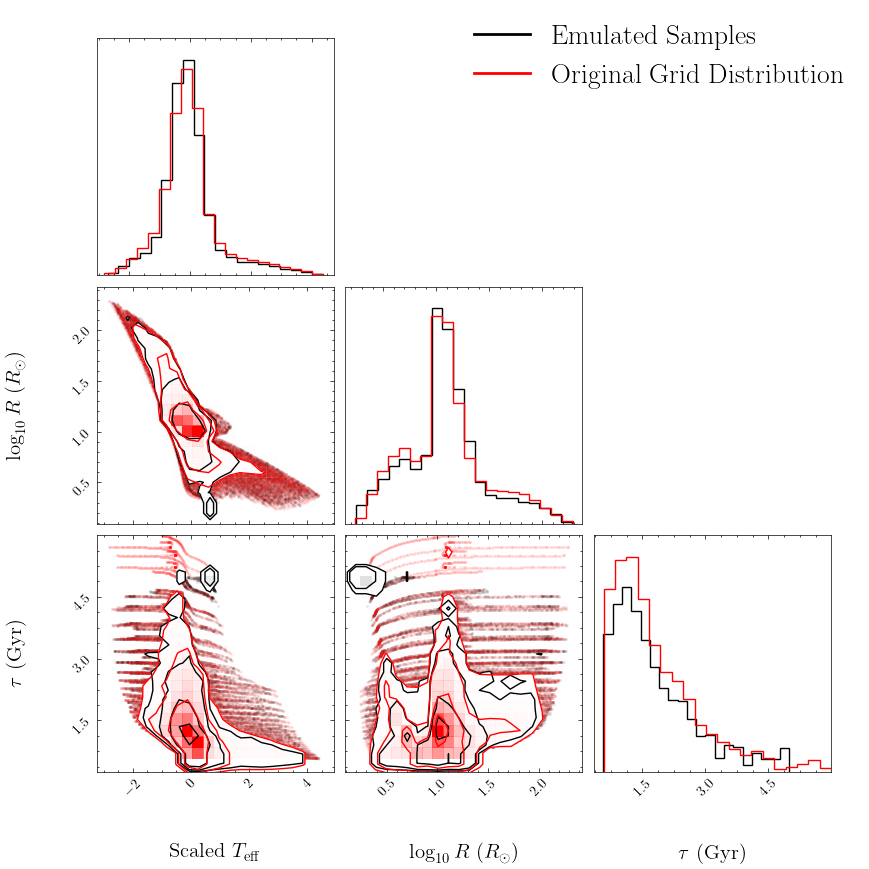

In [30]:
fig = plt.figure(figsize=(9,9))

cond = y_logprobs > np.percentile(y_logprobs, 1)

labels = ['Scaled $T_{\\mathrm{eff}}$',
                  '$\\log_{10} R$ ($R_{\\odot}$)',
                  '$\\tau$ (Gyr)',
         ]

corner.corner(y_samps[cond],label_kwargs={"fontsize": fs}, fig=fig, labels=labels)
corner.corner(y_s, fig=fig, color='red')

handles = [plt.Line2D([0], [0], color='k', lw=2, label=r'Emulated Samples'),
           plt.Line2D([0], [0], color='red', lw=2, label=r'Original Grid Distribution')]

fig.legend(handles=handles, loc="upper right", fontsize=fs+5, frameon=False)

plt.show()

```{admonition} Exercise
:class: note

You have just trained a flow-based emulator on the training set without any form of validation. To assess its performance and generalizability, do the following:

- **Qualitative Evaluation**  
  - Visually compare the emulator's predictions to the original data distribution. In which regions of parameter space does the emulator struggle to reproduce the structure? Use the corner plot above as a reference.

- **Implement Validation**  
  - Define a `ValidationDataset` using `validation_df`.  
  - Integrate validation loss tracking into the training loop. Record the validation loss at each epoch.

- **Benchmarking**  
  - Quantitatively compare training and validation losses.  
  - Qualitatively assess the validation predictions using the same corner plot diagnostics.

*Optional*: Reflect on whether certain parameters (e.g. mass, age, [Fe/H]) are more difficult for the flow to capture. What might this suggest about the model's inductive bias or the density of training data in those regions?
```

Since the normalizing flow is a generative model, we **draw samples** from it in order to obtain predictions of observables like $T_{\mathrm{eff}}$ and radius. To obtain evolutionary tracks of a specific $\mathbf{y}$, (e.g., $M$, [Fe/H]) we specify their values in the conditioning vector $\mathbf{x}$.

### Scenario 1: Emulating an individual track

In [14]:
num_samps = 10000
fixed_mass = 1.9
fixed_met = 0.0

cond_vec_single = np.zeros((num_samps, X_train.size(1)))  # shape of (N, num initial parameters)
cond_vec_single[:,0] = fixed_mass  # first column is for init mass
cond_vec_single[:,1] = fixed_met # second column is for init met #np.random.uniform(low=0.25, high=-1.25, size=num_samps)
cond_vec_single = torch.Tensor(cond_vec_single).to(device)

single_track_prediction = flow(cond_vec_single).sample().data.cpu().numpy()  # shape of (N, num output observables)

### Scenario 2: Emulating a continuum of tracks
Similar to the linear interpolation example, we will fix the initial mass and observe the tracks across a range of initial metallicity:

In [15]:
num_samps = 100000
met_range = np.linspace(-1.25, 0.5, num_samps)

cond_vec_range = np.zeros((num_samps, X_train.size(1)))  # shape of (N, num initial parameters)
cond_vec_range[:,0] = fixed_mass  # first column is for init mass
cond_vec_range[:,1] = met_range # second column is for init met 
cond_vec_range = torch.Tensor(cond_vec_range).to(device)

range_track_prediction = flow(cond_vec_range).sample().data.cpu().numpy()  # shape of (N, num output observables)

In [16]:
def plot_emulation(single_track_prediction, range_track_prediction, met_range,
                  fixed_mass, fixed_met):
     
    fig = plt.figure(figsize=(12, 5))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    steps = np.unique(rg_grid.index.get_level_values('step').values)

    cmap = mpl.colormaps['viridis']
    norm = Normalize(vmin=met_range.min(), vmax=met_range.max())
    ax1.scatter(10**teff_scaler.inverse_transform(single_track_prediction[:,0].reshape(-1,1)), 
                10**single_track_prediction[:,1],
               s=2, c='k')         
    
    im2 = ax2.scatter(10**teff_scaler.inverse_transform(range_track_prediction[:,0].reshape(-1,1)), 
                10**range_track_prediction[:,1],
               s=2, c=met_range)
    
    for row in validation_massmet:
        if row[0] == fixed_mass:
            init_metallicity = row[1]
            ax1.plot( 10**validation_df.loc[(fixed_mass, init_metallicity, steps)]['teff'],
                     10**validation_df.loc[(fixed_mass, init_metallicity, steps)]['rad'], color='magenta',
                    lw=2)      
        
    for ax in [ax1, ax2]:         
        ax.set_yscale('log')
        ax.set_xlim(3000, 6500)
        ax.set_ylim(3, 180)
        ax.invert_xaxis()
        ax.set_xlabel('$T_{\\mathrm{eff}}$ (K)', fontsize=fs)
        ax.set_ylabel('Radius ($R_{\\odot}$)', fontsize=fs)

    ax1.plot([],[], color='magenta',
                lw=2, label='Holdout Tracks\nat %.1f$M_{\\odot}$' %fixed_mass)
    ax1.scatter([],[], c='k',
                s=55, label='Emulated %.1f$M_{\\odot}$\n%.2f dex Track' %(fixed_mass, fixed_met))
    ax1.legend(loc='lower right', prop={'size': fs-3})
    ax1.text(x=0.1, y=0.9, s=f'Holdout Initial [Fe/H] from {met_range[0]:.2f} to {met_range[-1]:.2f} dex\nin increments of 0.25 dex',
            transform=ax1.transAxes, color='magenta')
    
    cbar = fig.colorbar(im2, ax=ax2, label='Initial Metallicity (dex)')
    plt.show()

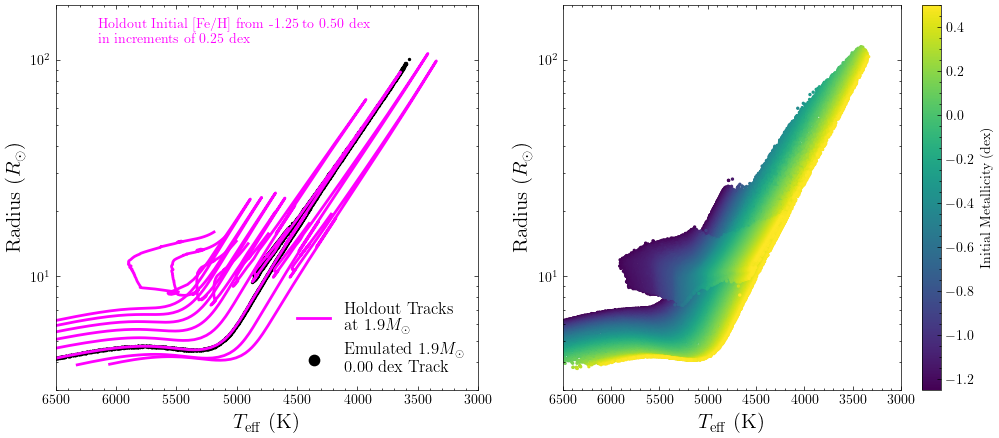

In [17]:
plot_emulation(single_track_prediction, range_track_prediction, met_range, fixed_mass, fixed_met)

Observe that in defining $\mathbf{x}$, namely `cond_vec_single` and `cond_vec_range`, a separate column for EEP is not required. Indeed, this is one of the key strengths of the flow -- in that interpolation can be done without having to explicitly enforce sampling regularity of models in the grid.   

## Flow-based Stellar Parameter Inference: Sampling-Importance Resampling

Once trained, the Conditional Normalizing Flow (CNF) provides a **smooth, differentiable mapping** between stellar model input parameters $\mathbf{x}$ (e.g., mass, metallicity) and their corresponding observables $\mathbf{y}$ (e.g., $T_\mathrm{eff}$, $\log g$, radius). Combined with its generative capability, the CNF is a powerful tool for stellar parameter inference using sampling-based approaches.

### Sampling/Importance Resampling (SIR)

Using the CNF, we can perform **Sampling/Importance Resampling (SIR)**, a classical Bayesian technique, to approximate the posterior $p(\mathbf{x}|\mathbf{y}_\mathrm{obs})$. 

> Given an observation $\mathbf{y}_\mathrm{obs}$, we would like to know what is its properties $\mathbf{x}$ based on our (emulated) grid of models.

1. Sample from the prior $p(\mathbf{x})$.
2. Map each sample $\mathbf{x}$ to predicted observables $\mathbf{y}$ using the CNF.
3. Weight each sample using a likelihood $\mathcal{L}(\mathbf{y}_\mathrm{obs} | \mathbf{y})$.
4. Resample according to these weights to approximate the posterior.

This approach provides an intuitive analysis of how observed data shapes the inferred parameters.


```{admonition} For the Statistically-Minded
:class: dropdown

In Bayesian inference, we often seek to estimate the posterior distribution:

$$
p(\phi \mid \text{data}) \propto \mathcal{L}(\phi) \, p(\phi),
$$

where $p(\phi)$ is the prior and $\mathcal{L}(\phi)$ is the likelihood of the observed data.

**Sampling/Importance Resampling (SIR)** offers a way to approximate this distribution via the following steps:

1. Sample points $\phi_i$ from a proposal distribution $g(\phi)$ (e.g., the prior).
2. Compute importance weights:  
   $
   \omega_i = \frac{\mathcal{L}(\phi_i) \, p(\phi_i)}{g(\phi_i)}.
   $
3. Normalize the weights:  
   $
   q_i = \frac{\omega_i}{\sum_j \omega_j}.
   $
4. Resample: Draw $N$ new samples from the $\phi_i$ values according to the weights $q_i$.

> In the special case where $g(\phi) = p(\phi)$, the importance weights simplify to:
>
> $q_i \propto \mathcal{L}(\phi_i)$.
>
> That is, the posterior can be approximated by **reweighting the prior samples using the likelihood**.

This is the core idea behind using CNFs for inference: draw from the prior, pass through the CNF to generate observables, compute likelihoods, and reweight to approximate the posterior.

```
### A Visual Example of Sampling/Importance Resampling (SIR)

In the following, we show how the SIR algorithm gives us an intuitive way of getting posterior samples by reweighting samples generated from the flow.

We first begin by generating samples from the prior. Here, we assume that both initial mass and metallicity are **uniformly distributed**.


In [ ]:
num_samps = 100000
mass_range = np.random.uniform(min(x_mass_subsampled), max(x_mass_subsampled), num_samps)
met_range = np.random.uniform(min(x_feh_subsampled), max(x_feh_subsampled), num_samps)

We then pass these samples through the normalizing flow:

In [85]:
cond_vec = np.zeros((num_samps, X_train.size(1)))  # shape of (N, num initial parameters)
cond_vec[:,0] = mass_range  # first column is for init mass
cond_vec[:,1] = met_range # second column is for init met 
cond_vec = torch.Tensor(cond_vec).to(device)

flow_samples = flow(cond_vec).sample().data.cpu().numpy()  # shape of (N, num output observables)

The following code block `plot_prior` implements SIR as well as the plotting for the samples representing the prior and the observables.

In [94]:
def plot_prior(y, x, teff_constraint=None, rad_constraint=None):
    
    ####### Sampling/Importance Resampling (SIR) ########
    
    x = x.data.cpu().numpy() ## Prior Samples
    
    
    pred_teff = 10**teff_scaler.inverse_transform(y[:,0].reshape(-1,1))  ## Observables
    pred_rad = 10**y[:,1]
    pred_age = y[:,2]
    
    draw_prob_teff = draw_prob_rad = np.ones_like(x[:,0]) ## Initializing Observable Vector
    
    
    #### Applying Constraints From Observable Vector Y Into Likelihoods ####
    
    if teff_constraint is not None:
        draw_prob_teff = 1/(teff_constraint[1]*np.sqrt(2*np.pi))  * np.exp(-0.5*np.power( pred_teff - teff_constraint[0], 2)/ teff_constraint[1]**2)     
        
    if rad_constraint is not None:
        draw_prob_rad = 1/(rad_constraint[1]*np.sqrt(2*np.pi))  * np.exp(-0.5*np.power( pred_rad - rad_constraint[0], 2)/ rad_constraint[1]**2)     
    
    draw_prob = draw_prob_teff.squeeze() * draw_prob_rad.squeeze() # Joint Likelihood
    
    
    #### Resampling X (prior) based on the Joint Likelihood ####
    
    resampled_prior = np.array(random.choices(x, 
                                 weights=draw_prob , k=100000))    
    
    
    
    ####### Plotting ########
    
    cmap = mpl.colormaps['viridis']
    norm = Normalize(vmin=y[:,2].min(), vmax=y[:,2].max())
    
    fig = plt.figure(figsize=(12, 5))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    
    ax1.scatter(x[:,0], x[:,1],
               s=2, c=y[:,2], label='Prior Samples, $\\mathbf{x}$')         
    im2 = ax2.scatter(pred_teff, 
                pred_rad,
               s=2, c=pred_age)
    
    if (teff_constraint is not None) or (rad_constraint is not None):
        
        ax1.scatter(resampled_prior[:,0], resampled_prior[:,1], s=5, c='r', edgecolor='k', lw=0.25,
                   label = 'Resampled Prior')
        
        sc = ax2.scatter(pred_teff[draw_prob > 1e-9], 
                    pred_rad[draw_prob > 1e-9],
                   s=2, c=np.log10(draw_prob[draw_prob > 1e-9]),
                   cmap='inferno', zorder=999)
        
        cax = inset_axes(ax2, 
                 width="40%",  
                 height="3%", 
                 loc='upper right',
                 bbox_to_anchor=(0.05, -0.35, 0.9, 0.5),
                 bbox_transform=ax2.transAxes,
                 borderpad=0)

        cb = plt.colorbar(sc, cax=cax, orientation='horizontal')
        cb.set_label(r'log-likelihood', fontsize=10)
        cb.ax.tick_params(labelsize=8)
         
        ax1.legend(prop={'size': fs}, framealpha=1, frameon=1, loc='upper right')

    ax1.set_xlabel('Initial Mass ($M_{\\odot}$)', fontsize=fs)
    ax1.set_ylabel('Initial [Fe/H] (dex)', fontsize=fs)
    ax2.set_yscale('log')
    ax2.set_xlim(3000, 6500)
    ax2.set_ylim(1.8, 180)
    ax2.invert_xaxis()
    ax2.set_xlabel('$T_{\\mathrm{eff}}$ (K)', fontsize=fs)
    ax2.set_ylabel('Radius ($R_{\\odot}$)', fontsize=fs)
    
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.1265, 0.89, 0.7735, 0.05]) 
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label('Model Age (Gyr)', fontsize=fs)
    
    plt.show()

First, we visualize the prior, $\mathbf{x}$, on the left and the corresponding observable distribution $\mathbf{y}$ on the right. These are **samples from the flow** and are colored by age -- notice how samples of a specific initial mass and metallicity in the prior occupy specific regions in the observable space!

This occurs because the flow provides a **one-to-one mapping** between $\mathbf{x}$ and $\mathbf{y}$, enabling us to push forward the prior into observable space and evaluate likelihoods directly.

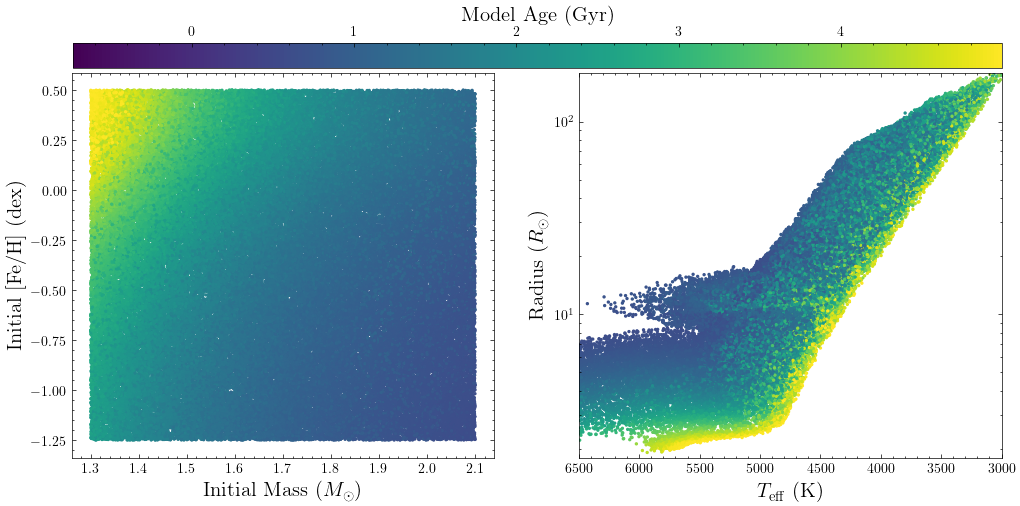

In [87]:
plot_prior(flow_samples, cond_vec)

Next, we visualize the prior samples after applying a Gaussian likelihood $T_{\mathrm{eff}}$ constraint to the $T_{\mathrm{eff}}-R$ space:

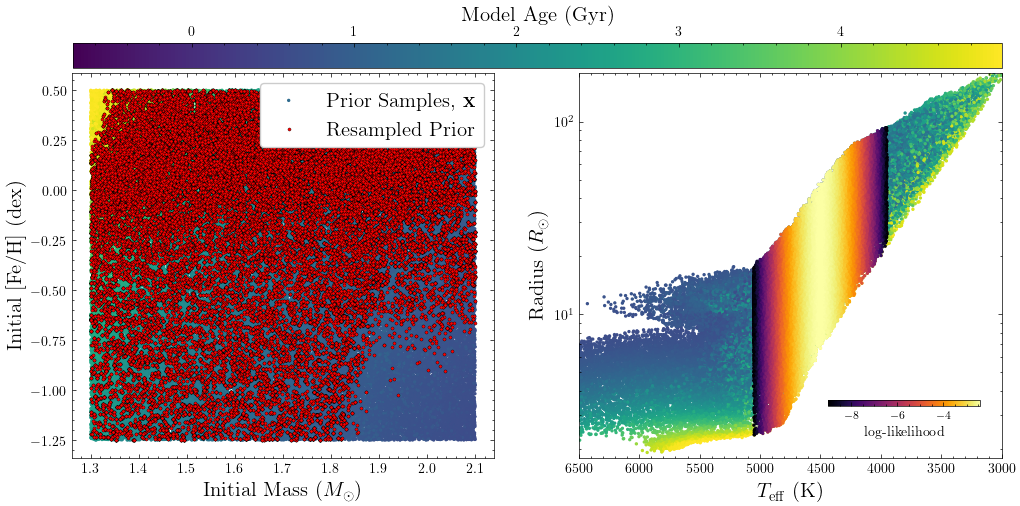

In [95]:
plot_prior(flow_samples, cond_vec, teff_constraint = (4500, 100))

Note the reduction in the prior space occupied by the samples -- this is because they have been **resampled with weights following the likelihood** from the observed space.

We now further add on a constraint in radius:

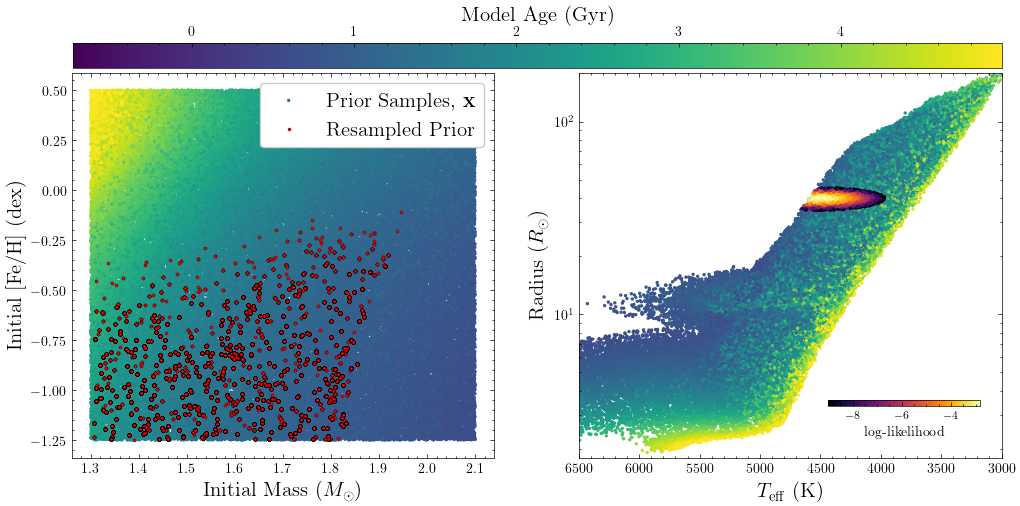

In [96]:
plot_prior(flow_samples, cond_vec, teff_constraint = (4500, 100), rad_constraint = (40, 1))

The region occupied in the prior space shrinks correspondingly. The remaining samples is approximately distributed according to the posterior distribution.


```{admonition} Duality of Constraints
:class: note
In the above example, we have limited samples from the flow by applying constraints to the observables $\mathbf{y}$ through Gaussian likelihoods. 

1. Can we perform the converse, which is to directly manipulate $\mathbf{x}$ to change the distribution of
$\mathbf{y}$ sampled from the flow? 
- Which part of the code needs to be altered to do this?
- Under what circumstances would we need to do this?


2. From the one-to-one correspondence of the prior $\mathbf{x}$ with the observables $\mathbf{y}$, describe conceptually on how stellar ages are determined from the observed properties of a star using sampling-based approaches on a grid of models.

```


## See Also:

[Visualization on Importance Sampling](https://observablehq.com/@herbps10/importance-sampling)

[Flow-based Generative Emulation of Grids of Stellar Evolutionary Models](https://ui.adsabs.harvard.edu/abs/2024ApJ...973..154H/abstract)

The [`modelflows`](https://github.com/mtyhon/modelflows) library